## Ismail Sherif's Notebook

#### 1. Deep Learning Approach (LSTM & GRU)

I initially attempted to build Recurrent Neural Networks (RNN) using both Long Short-Term Memory (LSTM) and Gated Recurrent Unit (GRU) architectures. However, with only 14K records, the dataset proved too small for these deep learning models. Both LSTM and GRU models showed signs of underfitting:

- Training/validation accuracy: ~59-60%
- Training loss: ~0.84

[Click Here](https://colab.research.google.com/drive/1fbXAAN6GACZNAPSPessAOXr1gXxmaNHt) to view the notebook FYI (_note_: this notebook is not part of the project)

Given these poor results, I pivoted to a different approach.

#### 2. Naive Bayes Approach

I then implemented a Naive Bayes classifier which showed much better performance on this dataset. However, I encountered a class imbalance issue where negative sentiment records outnumbered positive and neutral ones by approximately 3:1.

To address this, I applied the Synthetic Minority Over-Sampling Technique (SMOTE) to generate synthetic samples for the minority classes (positive and neutral), thereby balancing the class distribution.


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_score, f1_score, recall_score
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import cycle

import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from textblob import Word
from emot.emo_unicode import UNICODE_EMOJI, EMOTICONS_EMO
from autocorrect import Speller

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ismai\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ismai\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\ismai\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [2]:
def preprocess_text(text):
    abbreviation_dict = {
        "u": "you", "bked": "booked", "thx": "thanks", "plz": "please",
        "sfo": "san francisco airport", "lax": "los angeles airport",
        "nyc": "new york city", "bos": "boston", "las": "las vegas",
        "dal": "dallas", "dca": "washington, d.c.", "lg": "likely good"
    }
    english_contractions_dict = {
        "ain't": "am not", "aren't": "are not", "can't": "cannot", "can't've": "cannot have",
        "could've": "could have", "couldn't": "could not", "couldn't've": "could not have",
        "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not",
        "hasn't": "has not", "haven't": "have not", "he'd": "he would", "he'll": "he will",
        "he's": "he is", "how'd": "how did", "how'll": "how will", "how's": "how is",
        "i'd": "i would", "i'll": "i will", "i'm": "i am", "i've": "i have", "isn't": "is not",
        "it'd": "it would", "it'll": "it will", "it's": "it is", "let's": "let us",
        "ma'am": "madam", "might've": "might have", "mightn't": "might not", "must've": "must have",
        "mustn't": "must not", "needn't": "need not", "shan't": "shall not", "she'd": "she would",
        "she'll": "she will", "she's": "she is", "should've": "should have", "shouldn't": "should not",
        "that'd": "that would", "that's": "that is", "there's": "there is", "they'd": "they would",
        "they'll": "they will", "they're": "they are", "they've": "they have", "wasn't": "was not",
        "we'd": "we would", "we're": "we are", "we've": "we have", "weren't": "were not",
        "what'll": "what will", "what're": "what are", "what's": "what is", "what've": "what have",
        "where's": "where is", "who's": "who is", "who've": "who have", "won't": "will not",
        "would've": "would have", "wouldn't": "would not", "you'd": "you would", "you'll": "you will",
        "you're": "you are", "you've": "you have"
    }
    spell = Speller(lang='en')
    english_stopwords = stopwords.words("english")

    text = text.lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@\S+', '', text)

    words = text.split()
    new_words = [abbreviation_dict.get(word, word) for word in words]
    text = " ".join(new_words)

    words = text.split()
    new_words = [english_contractions_dict.get(word, word) for word in words]
    text = " ".join(new_words)

    for emot in UNICODE_EMOJI:
        if emot in text:
            text = text.replace(
                emot,
                " " + UNICODE_EMOJI[emot].replace(":", "").replace(",", "").replace("_", " ") + " "
            ).lower()
    for emo in EMOTICONS_EMO:
        if emo in text:
            text = text.replace(
                emo,
                " " + EMOTICONS_EMO[emo].replace(":", "").replace(",", "").replace("_", " ") + " "
            ).lower()

    text = re.sub(r'[^\w\s]', '', text)
    text = " ".join(x for x in text.split() if x.lower() not in english_stopwords)
    text = ' '.join(spell(word) for word in text.split())
    text = " ".join(Word(word).lemmatize() for word in text.split())
    tokens = word_tokenize(text)

    return tokens

In [3]:
df = pd.read_csv('../../../data/clean_Tweets.csv')

X = df['text']
y = df['airline_sentiment']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=19)

In [5]:
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [6]:
# handling data imbalance
smote = SMOTE(random_state=19)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)

# from imblearn.over_sampling import RandomOverSampler
# rus = RandomUnderSampler(random_state=42)
# X_train_resampled, y_train_resampled = rus.fit_resample(X_train_tfidf, y_train)

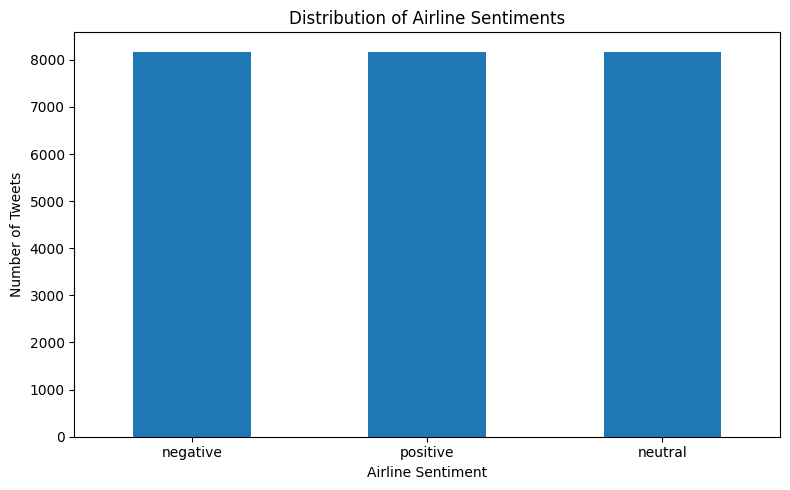

Distribution of Airline Sentiments chart is saved as src/airline_sentiment_distribution_bar_chart.png


In [7]:
# calculating value counts for "airline_sentiment"
sentiment_counts = y_train_resampled.value_counts()

plt.figure(figsize=(8, 5))
sentiment_counts.plot(kind='bar')
plt.xlabel('Airline Sentiment')
plt.ylabel('Number of Tweets')
plt.title('Distribution of Airline Sentiments')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()
print("Distribution of Airline Sentiments chart is saved as src/airline_sentiment_distribution_bar_chart.png")

In [8]:
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_resampled, y_train_resampled)

MultinomialNB()

In [9]:
# Logistic Regression
lr_classifier = LogisticRegression(random_state=42, max_iter=1000)
lr_classifier.fit(X_train_resampled, y_train_resampled)

# Make predictions
lr_train_pred = lr_classifier.predict(X_train_tfidf)
lr_test_pred = lr_classifier.predict(X_test_tfidf)

# Calculate metrics
lr_train_accuracy = accuracy_score(y_train, lr_train_pred)
lr_test_accuracy = accuracy_score(y_test, lr_test_pred)

lr_train_precision = precision_score(y_train, lr_train_pred, average='weighted')
lr_train_recall = recall_score(y_train, lr_train_pred, average='weighted')
lr_train_f1 = f1_score(y_train, lr_train_pred, average='weighted')

lr_test_precision = precision_score(y_test, lr_test_pred, average='weighted')
lr_test_recall = recall_score(y_test, lr_test_pred, average='weighted')
lr_test_f1 = f1_score(y_test, lr_test_pred, average='weighted')

print("\nLogistic Regression Results:")
print(f"Training Accuracy: {lr_train_accuracy:.4f}")
print(f"Testing Accuracy: {lr_test_accuracy:.4f}")
print(f"\nTraining Metrics:")
print(f"Precision: {lr_train_precision:.4f}")
print(f"Recall: {lr_train_recall:.4f}")
print(f"F1-score: {lr_train_f1:.4f}")
print(f"\nTesting Metrics:")
print(f"Precision: {lr_test_precision:.4f}")
print(f"Recall: {lr_test_recall:.4f}")
print(f"F1-score: {lr_test_f1:.4f}")


Logistic Regression Results:
Training Accuracy: 0.8582
Testing Accuracy: 0.7720

Training Metrics:
Precision: 0.8652
Recall: 0.8582
F1-score: 0.8602

Testing Metrics:
Precision: 0.7890
Recall: 0.7720
F1-score: 0.7778


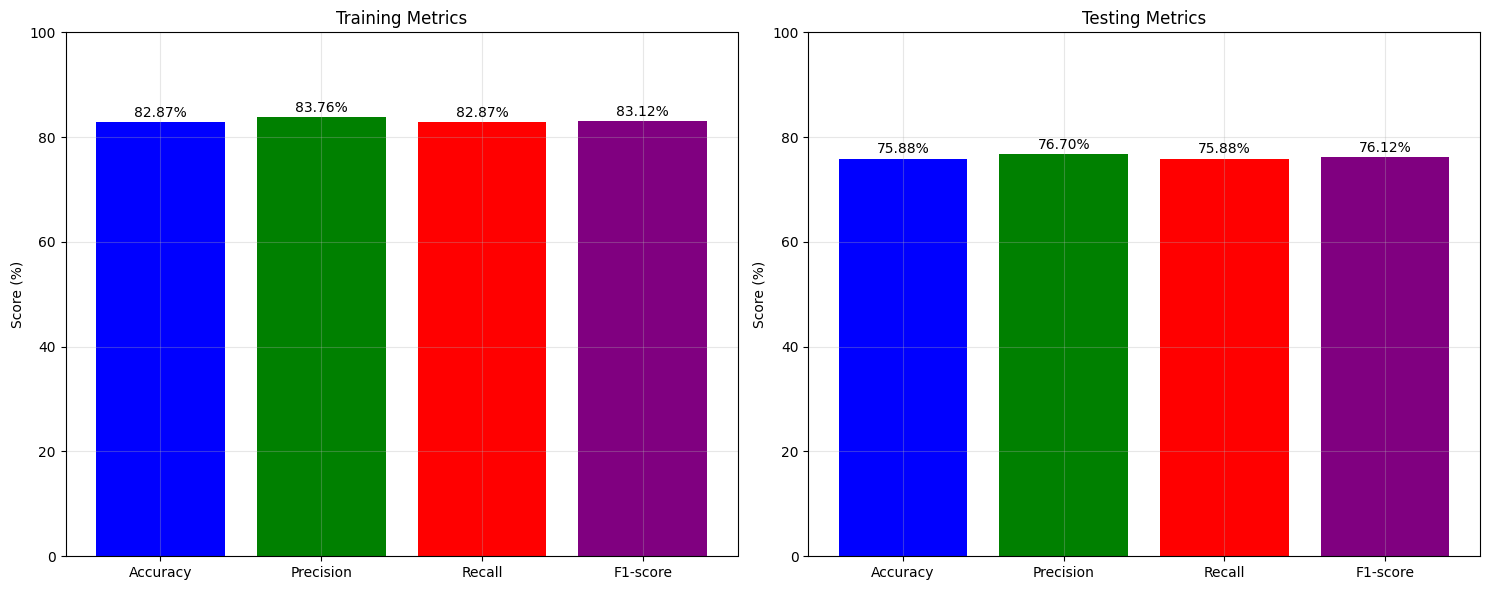


Detailed Classification Report:
              precision    recall  f1-score   support

    negative       0.87      0.82      0.84       906
     neutral       0.56      0.56      0.56       304
    positive       0.63      0.78      0.70       233

    accuracy                           0.76      1443
   macro avg       0.69      0.72      0.70      1443
weighted avg       0.77      0.76      0.76      1443



In [10]:
y_train_pred = nb_classifier.predict(X_train_tfidf)
y_test_pred = nb_classifier.predict(X_test_tfidf)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

train_precision = precision_score(y_train, y_train_pred, average='weighted')
train_recall = recall_score(y_train, y_train_pred, average='weighted')
train_f1 = f1_score(y_train, y_train_pred, average='weighted')

test_precision = precision_score(y_test, y_test_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

# Create metrics dictionary
metrics = {
    'Training': {
        'Accuracy': train_accuracy * 100,
        'Precision': train_precision * 100,
        'Recall': train_recall * 100,
        'F1-score': train_f1 * 100
    },
    'Testing': {
        'Accuracy': test_accuracy * 100,
        'Precision': test_precision * 100,
        'Recall': test_recall * 100,
        'F1-score': test_f1 * 100
    }
}

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot training metrics
metrics_train = list(metrics['Training'].values())
metrics_labels = list(metrics['Training'].keys())
ax1.bar(metrics_labels, metrics_train, color=['blue', 'green', 'red', 'purple'])
ax1.set_title('Training Metrics')
ax1.set_ylim(0, 100)
ax1.set_ylabel('Score (%)')
ax1.grid(True, alpha=0.3)
for i, v in enumerate(metrics_train):
    ax1.text(i, v + 1, f'{v:.2f}%', ha='center')

# Plot testing metrics
metrics_test = list(metrics['Testing'].values())
ax2.bar(metrics_labels, metrics_test, color=['blue', 'green', 'red', 'purple'])
ax2.set_title('Testing Metrics')
ax2.set_ylim(0, 100)
ax2.set_ylabel('Score (%)')
ax2.grid(True, alpha=0.3)
for i, v in enumerate(metrics_test):
    ax2.text(i, v + 1, f'{v:.2f}%', ha='center')

plt.savefig("src/nb_random_over_samp_tfidf.png.png")
plt.tight_layout()
plt.show()
# Print classification report for detailed metrics
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_test_pred))

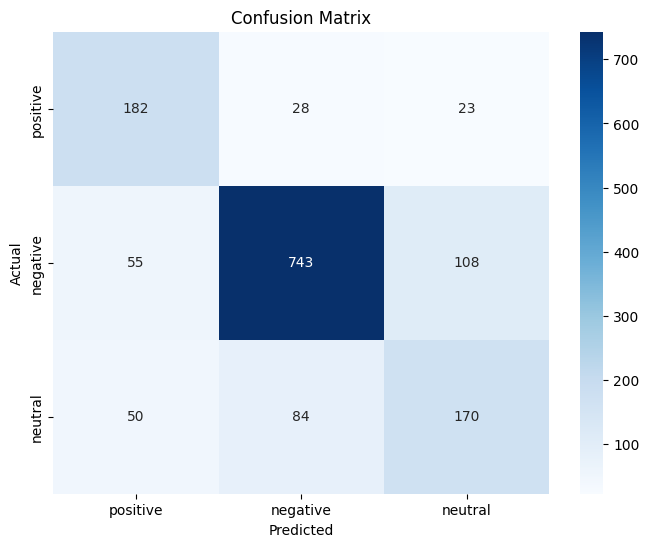

In [11]:
cm = confusion_matrix(y_test, y_test_pred, labels=['positive', 'negative', 'neutral'])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['positive', 'negative', 'neutral'], yticklabels=['positive', 'negative', 'neutral'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

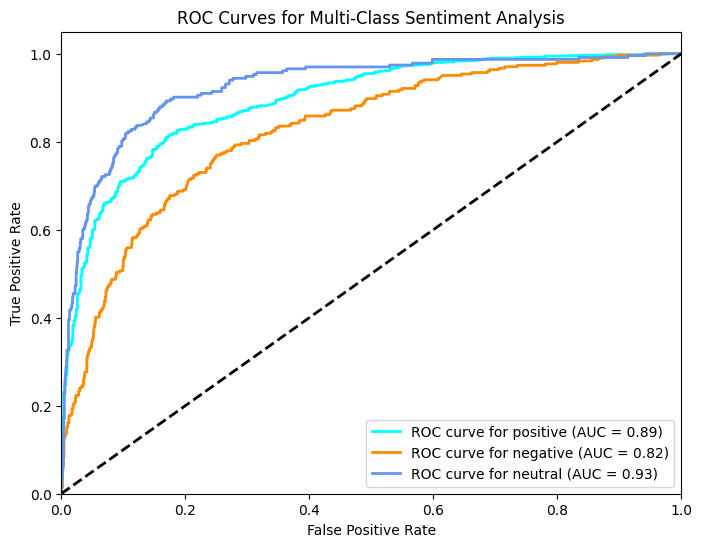

In [12]:
y_score = nb_classifier.predict_proba(X_test_tfidf)
classes = ['positive', 'negative', 'neutral']
y_test_bin = pd.get_dummies(y_test).values
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(len(classes)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve for {classes[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Multi-Class Sentiment Analysis')
plt.legend(loc="lower right")
plt.show()

In [13]:
text = "great flight amazing service"
text = "worst flight ever"
text = "I am going to my school"

text_tokenized = preprocess_text(text)
text_tfidf = vectorizer.transform([text])
prediction = nb_classifier.predict(text_tfidf)

print(f"\nExample Tweet: '{text}'")
print(f"Predicted Sentiment: {prediction[0]}")


Example Tweet: 'I am going to my school'
Predicted Sentiment: neutral
